In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [117]:
class KMeansClustering(object):
    """Initializes `KMeansClustering` class instance.

    Attributes:
        num_points: int, number of input points to cluster.
        num_dims: int, number of dimensions of input points.
        num_clusters: int, number of clusters to assign points to.
        max_iterations: int, maximum number of iterations to attempt
            convergence before exiting loop.
        batch_size: int, number of data instances within a batch.
        dataset: tf.data.Dataset, dataset that contains input points.
        points: tensor, rank 2 tensor of shape (num_points, num_dims) that
            contains the coordinates of each point.
        running_example_counts: tensor, rank 2 tensor of shape
            (num_clusters, 1) that maintains the running counts of examples
            assigned to each cluster.
        running_centroid_means: tensor, rank 2 tensor of shape
            (num_clusters, num_dims) that maintains the running means of
            examples assigned to each cluster.
        centroids: tf.Variable, rank 2 Variable of shape
            (num_clusters, num_dims) that contains the coordinates for each
            cluster centroid.
        assignments: tf.Variable, rank 1 Variable of shape (num_points,) that
            contains the cluster index assignment for each point.
        running_loss: tensor, rank 0 tensor of shape () that represents the
            running loss of the point assignment and centroid placement.
        old_loss: tensor, rank 0 tensor of shape () that represents the old
            loss of the point assignment and centroid placement.
    """
    def __init__(self, num_points, num_dims, num_clusters, max_iterations, batch_size):
        """Initializes `KMeansClustering` class instance.

        Args:
            num_points: int, number of input points to cluster.
            num_dims: int, number of dimensions of input points.
            num_clusters: int, number of clusters to assign points to.
            max_iterations: int, maximum number of iterations to attempt
                convergence before exiting loop.
            batch_size: int, number of data instances within a batch.
        """
        self.num_points = num_points
        self.num_dims = num_dims
        self.num_clusters = num_clusters
        self.max_iterations = max_iterations
        self.batch_size = batch_size

        self.dataset = None
        self.points = None

        # Initialize rolling centroid trackers.
        self.running_example_counts = tf.zeros(
            shape=(self.num_clusters, 1), dtype=tf.int64
        )

        self.running_centroid_means = tf.zeros(
            shape=(self.num_clusters, self.num_dims), dtype=tf.float32
        )

        # Initialize centroids.
        self.centroids = tf.Variable(
            initial_value=tf.zeros(
                shape=(self.num_clusters, self.num_dims), dtype=tf.float32
            ),
            trainable=False
        )

        # Initialize losses.
        self.running_loss = tf.zeros(shape=(), dtype=tf.float32)
        self.old_loss = tf.ones(shape=(), dtype=tf.float32) * tf.float32.max

    def get_dataset(self):
        """Gets tf.data.Dataset containing point data to cluster.
        """
        points = tf.constant(
            value=tf.random.uniform(
                shape=(self.num_points, self.num_dims), minval=0, maxval=10
            )
        )

        self.dataset = tf.data.Dataset.from_tensor_slices(tensors=points)
        self.dataset = self.dataset.batch(
            batch_size=self.batch_size, drop_remainder=False
        )

    def reset_running_tensors(self):
        """Resets running tensors back to zero.
        """
        self.running_example_counts = tf.zeros_like(
            input=self.running_example_counts, dtype=tf.int64
        )

        self.running_centroid_means = tf.zeros_like(
            input=self.running_centroid_means, dtype=tf.float32
        )

        self.running_loss = tf.zeros_like(
            input=self.running_loss, dtype=tf.float32
        )

    def find_closest_centroid_assignments(self, points):
        """Finds closest centroids for point assignments.

        Args:
            points: tensor, rank 2 tensor of shape (num_points, num_dims) that
                contains the coordinates of each point.
        """
        # Expand points and centroids to be able to do broadcast subtraction.
        self.points_expanded = tf.expand_dims(input=points, axis=0)
        self.centroids_expanded = tf.expand_dims(input=self.centroids, axis=1)

        # Calculate distances from points and centroids.
        distances = tf.math.reduce_sum(
            input_tensor=tf.square(
                x=self.points_expanded - self.centroids_expanded
            ),
            axis=2
        )

        # Assign points to closest centroid.
        self.assignments = tf.math.argmin(input=distances, axis=0)

        # Calculate loss using minimum euclidean distance.
        min_distances = tf.reduce_min(input_tensor=distances, axis=0)

        self.running_loss += tf.reduce_sum(input_tensor=min_distances)

    def compute_centroid_batch_means(self):
        """Computes centroid batch mean coordinates.
        """
        counts = []
        means = []
        # Loop through all clusters.
        for cluster_idx in range(self.num_clusters):
            # Find indices for points assigned to this cluster.
            # shape = (num_points_assigned, 1)
            cluster_assignment_indices = tf.where(
                tf.equal(
                    x=self.assignments, y=cluster_idx
                )
            )

            # Gather assigned points to cluster.
            # shape = (1, num_points_assigned, num_dims)
            cluster_assigned_points = tf.gather(
                params=self.points,
                indices=tf.reshape(
                    tensor=cluster_assignment_indices,
                    shape=[1, -1]
                )
            )

            # Get cluster mean values for each dimension.
            # shape = (1, num_dims)
            cluster_mean = tf.math.reduce_mean(
                cluster_assigned_points,
                axis=1
            )

            # Append mean to list for concatenation after the loop.
            counts.append(
                tf.cast(x=cluster_assignment_indices.shape[0], dtype=tf.int64)
            )
            means.append(cluster_mean)

        # Calculate batch statistics.
        batch_counts = tf.expand_dims(tf.concat(values=counts, axis=0), axis=1)
        batch_means = tf.concat(values=means, axis=0)
        batch_sum = batch_means * tf.cast(x=batch_counts, dtype=tf.float32)

        # Add current batch's statistics to running statistics.
        running_sum = (
            self.running_centroid_means * tf.cast(
                x=self.running_example_counts, dtype=tf.float32
            )
        )

        self.running_example_counts += batch_counts
        self.running_centroid_means = tf.where(
            condition=tf.equal(x=batch_counts, y=0),
            x=self.running_centroid_means,
            y=tf.divide(
                x=running_sum + batch_sum,
                y=tf.cast(x=self.running_example_counts, dtype=tf.float32)
            )
        )

    @tf.function
    def assign_centroids(self, new_centroids):
        """Assigns new centroid coordinates to centroids variable.

        Args:
            new_centroids: tensor, rank 2 tensor that contains the coordinates
                for each n-dimensional centroid.
        """
        self.centroids.assign(value=new_centroids)

    def kmeans_clustering(self):
        """Performs kmeans clustering until convergence.
        """
        # Get dataset of points.
        self.get_dataset()

        # Perform iterations until convergence.
        for iteration in range(self.max_iterations):
            self.reset_running_tensors()
            for batch in self.dataset:
                if self.points is None:
                    # Initialize centroids at random point values.
                    self.assign_centroids(
                        new_centroids=tf.slice(
                            input_=tf.random.shuffle(value=batch),
                            begin=[0, 0],
                            size=[self.num_clusters, -1]
                        )
                    )
                self.points = batch

                # Find closest centroid assignments for batch of points.
                self.find_closest_centroid_assignments(self.points)

                # Break early if system has diverged (NaN).
                if self.running_loss != self.running_loss:
                    return

                # Compute centroids for batch of points.
                self.compute_centroid_batch_means()

            self.assign_centroids(new_centroids=self.running_centroid_means)

            print("Iteration {} has {} loss.".format(iteration, self.running_loss))
            # Break early if system has converged.
            if self.running_loss >= self.old_loss:
                return

            # Update loss.
            self.old_loss = self.running_loss
            

In [118]:
kmeans = KMeansClustering(
    num_points=200, num_dims=2, num_clusters=3, max_iterations=100, batch_size=7
)

In [119]:
kmeans.kmeans_clustering()

Iteration 0 has 2227.173095703125 loss.
Iteration 1 has 1452.1378173828125 loss.
Iteration 2 has 1408.1500244140625 loss.
Iteration 3 has 1384.968017578125 loss.
Iteration 4 has 1362.10888671875 loss.
Iteration 5 has 1353.0338134765625 loss.
Iteration 6 has 1350.6041259765625 loss.
Iteration 7 has 1350.6041259765625 loss.


In [115]:
kmeans.centroids

<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[2.4044113, 7.710298 ],
       [4.015902 , 2.0933225],
       [7.9469175, 5.4475665]], dtype=float32)>

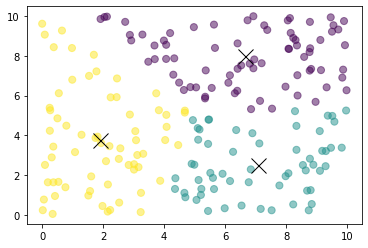

In [128]:
points = np.concatenate([batch for batch in kmeans.dataset], axis=0)
kmeans.find_closest_centroid_assignments(points)
plt.scatter(
    x=points[:, 0],
    y=points[:, 1],
    c=kmeans.assignments,
    s=50,
    alpha=0.5
)
plt.plot(
    kmeans.centroids[:, 0].numpy(),
    kmeans.centroids[:, 1].numpy(),
    "kx",
    markersize=15
)
plt.show()